## Get the data

This is the simulated data used in the DeepLIFT paper. The the pwms for the GATA motif and TAL motif (GATA_disc1 and TAL1_known1 from http://compbio.mit.edu/encode-motifs/) are used to generate motifs which are inserted into a random background. Sequences containing at least one GATA motif are a 1 for task 1, 0 otherwise. Sequences containing at least one TAL motif are a 1 for task 2, 0 otherwise. Sequences containing both a TAL and a GATA motif are a 1 for task 0. 

In [1]:
from __future__ import division, absolute_import, print_function
!./grab_data.sh

File sequences.simdata.gz exists already


In [2]:
try:
    import simdna
except ImportError, e:
    print("installing simdna package")
    !pip install -e "git://github.com/kundajelab/simdna.git@0.4.0#egg=simdna"
    print("\n******************************************************************************")
    print("RESTART THE JUPYTER KERNEL TO PICK UP ON THE INSTALLATION!!!")
    print("******************************************************************************")

In [3]:
import simdna.synthetic as synthetic
reload(synthetic)
reload(synthetic.core)
import gzip
data_filename = "sequences.simdata.gz"
data = synthetic.read_simdata_file(data_filename)

One-hot encode the sequence data into a 3d array, where the last axis ("channel" axis) is the ACGT axis.

In [4]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])
print(onehot_data.shape)

(8000, 200, 4)


## Compute the gapped kmer embeddings

We will compute the embeddings using the GPU to scan for matches to the gapped kmers, allowing for some numbed of mismatches. First, we will prepare the function that is going to do our scanning on the GPU.

In [5]:
import ssvmimp
import ssvmimp.train
reload(ssvmimp.train)

max_mismatches=1

filters, string_reps, embedding_func = ssvmimp.train.get_gapped_kmer_embedding_filters_and_func(
                                kmer_len=6, alphabet=['A','C','G','T'],
                                num_gaps=2, max_mismatches=max_mismatches)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)


'string_reps' stores string representations of the filters, as shown below (gaps are indicated with whitespace):

In [6]:
print("Number of filters:",len(string_reps))
print("First ten filters:")
print("\n".join(string_reps[:10]))
print("Last ten filters:")
print("\n".join(string_reps[-10:]))

Number of filters: 2560
First ten filters:
AAAA  
AAAC  
AAAG  
AAAT  
AACA  
AACC  
AACG  
AACT  
AAGA  
AAGC  
Last ten filters:
T  TCG
T  TCT
T  TGA
T  TGC
T  TGG
T  TGT
T  TTA
T  TTC
T  TTG
T  TTT


Now, we compute the embeddings, which are the sum of the number of matches to each filter per sequence, accounting for the desired number of mismatches

In [7]:
embeddings = embedding_func(onehot=onehot_data, batch_size=20, progress_update=500)

#normalize the embeddings so that the rows have unit magnitude
normalized_embeddings = embeddings/np.linalg.norm(embeddings, axis=1)[:,None]

print("Shape of the embeddings matrix:",normalized_embeddings.shape)

Done 0
Done 500
Done 1000
Done 1500
Done 2000
Done 2500
Done 3000
Done 3500
Done 4000
Done 4500
Done 5000
Done 5500
Done 6000
Done 6500
Done 7000
Done 7500
Shape of the embeddings matrix: (8000, 2560)


## Train SVMs given the embeddings

Train a linear classifier on task 1 ("GATA present") and task 2 ("TAL present"). Note that a classified trainer on task 0 ("both TAL and GATA present") doesn't perform very well because the concept of 'both' requires modeling logic that the linear SVM can't handle (I got around 50% accuracy when I tried it).

In [8]:
import sklearn.svm
import sys

train_set_num = 6000 #6000 examples will be used in the training set
print("Training t1")
sys.stdout.flush()
t1_classifier = sklearn.svm.LinearSVC().fit(X=normalized_embeddings[:train_set_num], y=data.labels[:train_set_num,1])
print("Training t2")
sys.stdout.flush()
t2_classifier = sklearn.svm.LinearSVC().fit(X=normalized_embeddings[:train_set_num], y=data.labels[:train_set_num,2])

Training t1
Training t2


Check the prediction accuracy on the testing set

In [9]:
for classifier, task in [(t1_classifier,1), (t2_classifier,2)]:
    preds = classifier.predict(normalized_embeddings[train_set_num:])
    print("Accuracy for task",task,":",np.sum(data.labels[train_set_num:,task] == preds)/len(preds))

Accuracy for task 1 : 0.905
Accuracy for task 2 : 0.917


## Inspect the top-scoring filters

Inspect the top-ranked filters for the two tasks by eye. coef_[0] stores the weights on the filters. As a reminder, the GATA PWM used was GATA_disc1 and the TAL motif used was TAL1_known1 from here: http://compbio.mit.edu/encode-motifs/. GATA is important for task 1 and TAL is important for task 2.

In [10]:
#get the top ranked filters for t1
print("t1 filters:")
assert len(string_reps)==len(t1_classifier.coef_[0])
t1_sorted_filters = sorted(zip(t1_classifier.coef_[0], string_reps), key=lambda x: -x[0])
print(t1_sorted_filters[:10])

print("t2 filters:")
assert len(string_reps)==len(t2_classifier.coef_[0])
t2_sorted_filters = sorted(zip(t2_classifier.coef_[0], string_reps), key=lambda x: -x[0])
print(t2_sorted_filters[:10])

t1 filters:
[(2.611071788366329, 'GCT A '), (2.5796085201603103, 'AGAA  '), (2.5748787246541873, 'A CAG '), (2.5366361144423251, 'G  GAG'), (2.5228007234867498, 'G TGA '), (2.5090632768877748, 'G T AT'), (2.4765269246432831, 'GAGA  '), (2.3918909669344339, 'GCT  G'), (2.353883378683451, 'G TCA '), (2.3479471733079165, 'GA A A')]
t2 filters:
[(3.0769530357852388, 'AGC G '), (2.7121137426883823, 'A CTG '), (2.6941829215096793, 'AG AG '), (2.61523197864582, 'CA  AG'), (2.5227950538054738, 'CA C G'), (2.5207916478331525, 'CTG T '), (2.5066892094086044, 'GC G T'), (2.4686781791371626, 'A G TG'), (2.3662444477534486, 'C G GG'), (2.3511903374712886, 'TG TG ')]


## Inspect the scores on specific kmers

The top ranked filters can be quite hard to make sense of. As a second sanity check, we look at the scores for the GATAAG kmer (strong match to the GATA motif) and the CAGATG kmer (strong match to the TAL motif) for task 0 and task 1.

In [11]:
import ssvmimp.interpret
reload(ssvmimp.interpret)
from collections import OrderedDict

t1_filter_to_score = OrderedDict(zip(string_reps, t1_classifier.coef_[0]))
t2_filter_to_score = OrderedDict(zip(string_reps, t2_classifier.coef_[0]))

print("Scores for GATAAG for task 1 and task 2:")
print(ssvmimp.interpret.get_total_kmer_score(
        kmer_string='GATAAG',
        filter_to_score=t1_filter_to_score,
        max_mismatches=max_mismatches))
print(ssvmimp.interpret.get_total_kmer_score(
        kmer_string='GATAAG',
        filter_to_score=t2_filter_to_score,
        max_mismatches=max_mismatches))

print("Scores for CAGATG for task 1 and task 2:")
print(ssvmimp.interpret.get_total_kmer_score(
        kmer_string='CAGATG',
        filter_to_score=t1_filter_to_score,
        max_mismatches=max_mismatches))
print(ssvmimp.interpret.get_total_kmer_score(
        kmer_string='CAGATG',
        filter_to_score=t2_filter_to_score,
        max_mismatches=max_mismatches))

Scores for GATAAG for task 1 and task 2:
169.490570316
-5.99698020945
Scores for CAGATG for task 1 and task 2:
8.54037770515
150.681516738


## Get position-specific scores

In [12]:
import ssvmimp.interpret
reload(ssvmimp.interpret)

t1_filter_imp_mats = ssvmimp.interpret.get_filter_imp_mats(
    filters=filters, scores=t1_classifier.coef_[0], max_mismatches=max_mismatches)
t2_filter_imp_mats = ssvmimp.interpret.get_filter_imp_mats(
    filters=filters, scores=t2_classifier.coef_[0], max_mismatches=max_mismatches)

On filter index: 0
On filter index: 500
On filter index: 1000
On filter index: 1500
On filter index: 2000
On filter index: 2500
On filter index: 0
On filter index: 500
On filter index: 1000
On filter index: 1500
On filter index: 2000
On filter index: 2500


In [62]:
import ssvmimp.backend.theano_backend
reload(ssvmimp.backend.theano_backend)
import ssvmimp.backend
reload(ssvmimp.backend)

t1_interpretation_func = ssvmimp.backend.get_interpretation_func(filters=filters, filter_imp_mats=t1_filter_imp_mats)
t2_interpretation_func = ssvmimp.backend.get_interpretation_func(filters=filters, filter_imp_mats=t2_filter_imp_mats)

In [63]:
t1_scores = t1_interpretation_func(onehot=onehot_data[-1000:], batch_size=20, progress_update=100)

Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900


In [66]:
t2_scores = t2_interpretation_func(onehot=onehot_data[-1000:], batch_size=20, progress_update=100)

Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900


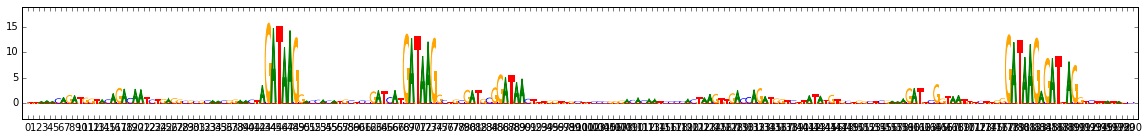

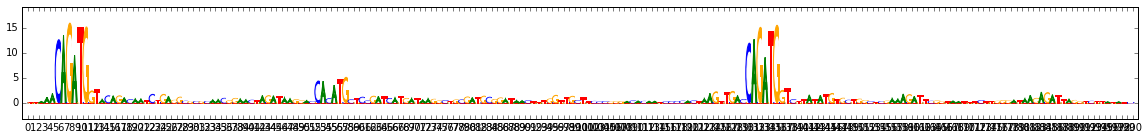

In [67]:
import ssvmimp.viz_sequence
reload(ssvmimp.viz_sequence)
%matplotlib inline

ssvmimp.viz_sequence.plot_weights(t1_scores[0])
ssvmimp.viz_sequence.plot_weights(t2_scores[0])